In [1]:
#!/usr/bin/env python
from __future__ import print_function
import sys
import numpy
#from pygsl import sf
from math import exp, sqrt, pi, erf
import cmath
from matplotlib import pyplot
import tables
import time

In [2]:
# spherical gaussian charge density
def gauss_density(x, y, z):
    global Q, sigma, size
    r2 = (x * x + y * y + z * z) * size**2
    return Q * exp(-r2 / (2 * sigma ** 2)) / (sigma * sqrt(2 * pi)) ** 3

In [3]:
# electric potential due to gauss_density
def gauss_field(x, y, z):
    global Q, sigma, epsilon0, size
    r = sqrt(x * x + y * y + z * z) * size
    if r == 0.0:
        return Q / (4.0 * pi * epsilon0) * sqrt(2.0) / (sqrt(pi) * sigma)
    return Q / (4.0 * pi * epsilon0 * r) * erf(r / (sqrt(2.0) * sigma));

In [4]:
c = 299792458.0
mu0 = 4 * pi * 1.0e-7
epsilon0 = 1.0 / (c * c * mu0)
e = 1.6021892e-19
Q = 1.7e11 * e

n_sigma = 8.0
sigma = 1.3e-3
n = 32
n2 = 2 * n
size = sigma * n_sigma
h = size / n
left = -size / 2.0 #+ h / 2.0

h = 1 / n
left = - 1 / 2.

In [5]:
def hockney_eastwood(coeff):
    rho2 = numpy.zeros([n2, n2, n2], numpy.float64)
    for i in range(0, n):
        x = left + i * h
        for j in range(0, n):
            y = left + j * h
            for k in range(0, n):
                z = left + k * h
                rho2[i, j, k] = gauss_density(x, y, z)

    G2 = numpy.zeros([n2, n2, n2], numpy.float64)
    G000 = coeff / h * size
    for i in range(0, n + 1):
        dx = i * h
        mi = n2 - i
        if (mi == n2):
            mi = i
        for j in range(0, n + 1):
            dy = j * h
            mj = n2 - j
            if (mj == n2):
                mj = j
            for k in range(0, n + 1):
                dz = k * h
                mk = n2 - k
                if (mk == n2):
                    mk = k
                if((i == 0) and (j == 0) and (k == 0)):
                    G2[0, 0, 0] = G000
                else:
                    G2[i, j, k] = 1.0 / sqrt(dx ** 2 + dy ** 2 + dz ** 2) / size
                # seven mirror images
                G2[mi, j, k] = G2[i, j, k]
                G2[mi, mj, k] = G2[i, j, k]
                G2[mi, mj, mk] = G2[i, j, k]
                G2[mi, j, mk] = G2[i, j, k]
                G2[i, mj, k] = G2[i, j, k]
                G2[i, mj, mk] = G2[i, j, k]
                G2[i, j, mk] = G2[i, j, k]

    rho2hat = numpy.fft.fftn(rho2)
    G2hat = numpy.fft.fftn(G2)
    phi2hat = numpy.zeros([n2, n2, n2], numpy.complex64)
    for i in range(0, n2):
        for j in range(0, n2):
            for k in range(0, n2):
                phi2hat[i, j, k] = rho2hat[i, j, k] * G2hat[i, j, k]

    phi2 = numpy.fft.ifftn(phi2hat)

    phi = numpy.zeros([n, n, n], numpy.float64)
    phie = numpy.zeros([n, n, n], numpy.float64)
    error = numpy.zeros([n, n, n], numpy.float64)

    xs = numpy.zeros([n, n, n], numpy.float64)
    ys = numpy.zeros([n, n, n], numpy.float64)
    zs = numpy.zeros([n, n, n], numpy.float64)

    for i in range(0, n):
        x = left + i * h
        for j in range(0, n):
            y = left + j * h
            for k in range(0, n):
                z = left + k * h
                phi[i, j, k] = phi2[i, j, k].real * h * h * h / (4 * pi * epsilon0) * size**3
                phie[i, j, k] = gauss_field(x, y, z)
                error[i, j, k] = (phie[i, j, k] - phi[i, j, k]) / phie[i, j, k]

                xs[i, j, k] = x
                ys[i, j, k] = y
                zs[i, j, k] = z

    max_error = numpy.max(numpy.max(numpy.max(error)))
    min_error = numpy.min(numpy.min(numpy.min(error)))
    mean_error = numpy.mean(numpy.mean(numpy.mean(abs(error))))

    print ("he erorrs:", max_error, min_error, mean_error)
    return phi, phie, max_error, min_error, mean_error

In [6]:
def vico_greengard_ferrando(phie):
    L = 1.8                 # gt sqrt(3)
    hs = pi / 2 + 1e-12
    hi = 1 / n
    n4 = 4 * n

    green = numpy.zeros([n4, n4, n4], numpy.float64) 
    factor = numpy.zeros([n4, n4, n4], numpy.complex128)

    for ii in range(0, n4):
        wm1 = -n * pi + ii * hs
        xx = -2 + ii * hi
        for jj in range(0, n4):
            wm2 = -n * pi + jj * hs
            yy = -2 + jj * hi
            for kk in range(0, n4):
                wm3 = -n * pi + kk * hs
                zz = -2 + kk * hi

                s = sqrt(wm1**2 + wm2**2 + wm3**2)
                green[ii, jj, kk] = 2 * (numpy.sin(L * s / 2) / s)**2

                factor[ii, jj, kk] = (16 * (2 * pi)**3) * cmath.exp(1j * (xx + yy + zz) * n * pi)

    T1 = factor * numpy.fft.ifftshift(numpy.fft.ifftn(green))
    T = T1[n:3*n, n:3*n, n:3*n]

    rho2 = numpy.zeros([n2, n2, n2], numpy.float64)
    for i in range(0, n):
        x = left + i * h
        for j in range(0, n):
            y = left + j * h
            for k in range(0, n):
                z = left + k * h
                rho2[i, j, k] = gauss_density(x, y, z)

    #rho2hat = numpy.fft.fftn(rho2)
    #T2hat = numpy.fft.fftn(T)
    #phi_vgf2 = numpy.zeros([n2, n2, n2], numpy.complex128)
    #for i in range(0, n2):
    #    for j in range(0, n2):
    #        for k in range(0, n2):
    #            phi_vgf2[i, j, k] = rho2hat[i, j, k] * T2hat[i, j, k]
    #phi_vgf = (Q / epsilon0) * numpy.fft.ifftn(phi_vgf2).real[n:, n:, n:]

    phi_vgf2 = numpy.fft.ifftn(numpy.fft.fftn(T) * numpy.fft.fftn(rho2))
    phi_vgf = (Q / epsilon0) * phi_vgf2.real[n:, n:, n:]

    #print (T1.shape, T.shape, phi_vgf2.shape, phi_vgf2.real.shape)
    #print (T1.dtype, T.dtype, phi_vgf2.dtype, phi_vgf2.real.dtype) 
    #print (rho2.dtype, rho2.shape)
    #print (phi_vgf.dtype, phi_vgf.shape)

    error = phie - phi_vgf
    max_error = numpy.max(numpy.max(numpy.max(error)))
    min_error = numpy.min(numpy.min(numpy.min(error)))
    mean_error = numpy.mean(numpy.mean(numpy.mean(abs(error))))

    print ("vgf errors:", max_error, min_error, mean_error)
    return phi_vgf, phie, max_error, min_error, mean_error

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
he erorrs: 0.014127408940149857 0.00014955813463723216 0.000811110793463334
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
vgf errors: 93.35919495907729 19.9809837169596 38.340106580036334
1.0006217649077433


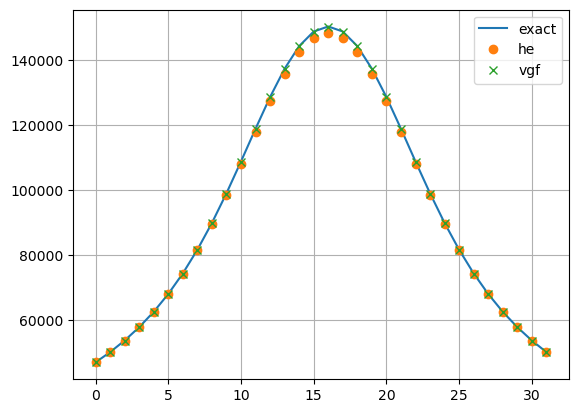

In [7]:
#t0 = time.time()
#phie = gauss_field()    
#t1 = time.time()
%time
phi_he, phie, mae, mie, mee = hockney_eastwood(coeff=2.8)
#t2 = time.time()
%time
phi_vgf, phie_vgf, mae_vgf, mie_vgf, mee_vgf = vico_greengard_ferrando(phie)
#t3 = time.time()

# comparison point
p = n // 2
print (phie[p,p,p] / phi_vgf[p,p,p])
pyplot.plot(phie[:, p, p], label='exact')
pyplot.plot(phi_he[:, p, p], 'o', label='he')
pyplot.plot(phi_vgf[:, p, p], 'x', label='vgf')
pyplot.legend(loc='best')
pyplot.grid(1)

#print (t1-t0, t2-t1, t3-t2)